In [23]:
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd

# Read the peak file (replace 'peaks.bed' with your file)
# Assuming the file has columns: chrom, start, end, name, score
peaks = pd.read_csv('HK2-TEAD1-rep1_S8.sorted_summits.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score'])


In [24]:

# Read the ground truth file (replace 'ground_truth.bed' with your file)
# Assuming the file has columns: chrom, start, end, label (1 for true positive, 0 for true negative)
# Load file
df = pd.read_csv('ENCFF842NIH.bed', sep='\t', header=None)
# Check the first few rows to ensure it looks as expected
print(df.head())
# Select only the first three (or six) columns
ground_truth = df.iloc[:, :3]  # Change :3 to :6 for BED6 format
# Ensure the coordinates are integers
ground_truth[1] = ground_truth[1].astype(int)
ground_truth[2] = ground_truth[2].astype(int)
# Check for missing values
if ground_truth.isnull().values.any():
    print('Warning: Missing values found!')
ground_truth['label'] = 1


       0          1          2  3     4  5          6    7        8    9
0  chr11   66421610   66421968  .  1000  .  544.34586 -1.0  3.95051  185
1  chr19   49987148   49987490  .  1000  .  431.15181 -1.0  3.95051  156
2   chr4    1410481    1410753  .  1000  .  349.89638 -1.0  3.95051  127
3   chr8  141715996  141716260  .  1000  .  346.08013 -1.0  3.95051  123
4  chr11   63671464   63671687  .  1000  .  323.86550 -1.0  3.95051  119


In [25]:

# Since the peaks and ground truth may not align perfectly, 
# we need a way to assign each peak to a ground truth. 
# This could be done using a variety of methods depending on your specific case. 
# Here, we simply intersect the peaks with the ground truth using bedtools, 
# and assign the label of the ground truth to the intersecting peak. 
# If a peak intersects multiple ground truths, you'll need to decide how to handle it.

# You might need to install bedtools and pybedtools. You can do this using:
# !apt-get install bedtools
# !pip install pybedtools

from pybedtools import BedTool

# Convert dataframes to BedTool objects
peaks_bt = BedTool.from_dataframe(peaks)
ground_truth_bt = BedTool.from_dataframe(ground_truth)
peaks_bt

<BedTool(/var/folders/hf/9j3b1zq945b3625r6__5s1qm0000gn/T/pybedtools.mcc0uzsa.tmp)>

In [21]:

# Intersect peaks with ground truth, wa keeps the original peak, wb keeps the intersected ground truth
intersected = peaks_bt.intersect(ground_truth_bt, wa=True, wb=True)


/opt/homebrew/anaconda3/envs/genomics3.8/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


AUROC:  nan


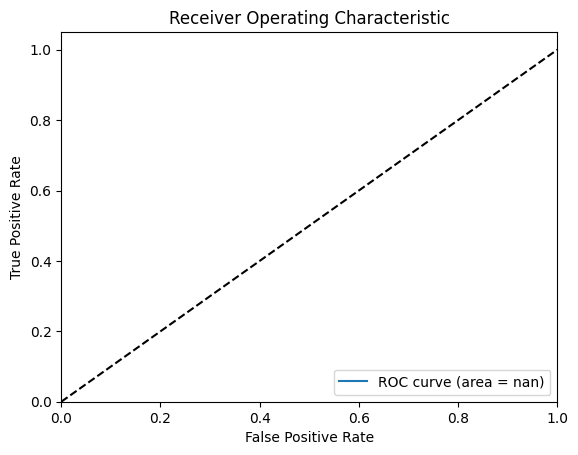

In [22]:

# Convert back to DataFrame
intersected_df = intersected.to_dataframe(names=['chrom', 'start', 'end', 'name', 'score', 'chrom_gt', 'start_gt', 'end_gt', 'label'])

# Now you should have a DataFrame where each peak has a corresponding label and score
y_true = intersected_df['label'].values
y_scores = intersected_df['score'].values

# Calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)

# Calculate AUROC
auroc = metrics.auc(fpr, tpr)

print('AUROC: ', auroc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
